## Deadline

Wednesday, November 22, 2017, 11:59PM

## Important notes

- When you push your Notebook to GitHub, all the cells must already have been evaluated.
- Don't forget to add a textual description of your thought process and of any assumptions you've made.
- Please write all your comments in English, and use meaningful variable names in your code.

## Question 1: Propensity score matching

In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 5 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to brush up your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.

#### 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

What might a naive "researcher" conclude from this superficial analysis?

#### 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

#### 3. A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `sklearn` to fit the logistic regression model and apply it to each data point to obtain propensity scores:

```python
from sklearn import linear_model
logistic = linear_model.LogisticRegression()
```

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).)

#### 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?


#### 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.


#### 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

In [233]:
la = pd.read_csv('lalonde.csv')
la.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


## 1. A naive analysis

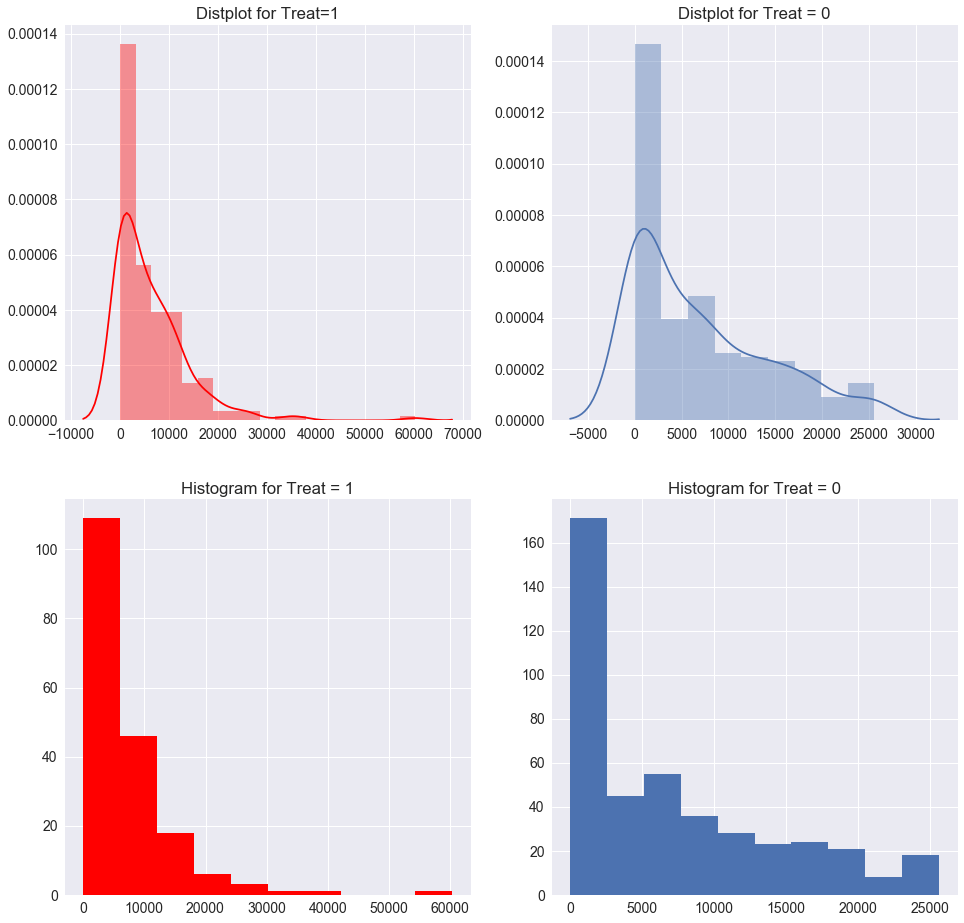

,Treat = 1,Treat = 0
count,185.000000,429.000000
mean,6349.143530,6984.169742
std,7867.402218,7294.161791
min,0.000000,0.000000
25%,485.229800,220.181300
50%,4232.309000,4975.505000
75%,9642.999000,11688.820000
max,60307.930000,25564.670000


In [235]:
fig, axes = plt.subplots(2, 2, figsize=(16,16))

x  = np.round(np.array(la[la['treat']==1]['re78'])/100)*100
y = np.round(np.array(la[la['treat']==0]['re78'])/100)*100

ay = plt.subplot(2, 2, 1)
ay.set_title('Distplot for Treat=1')
sns.distplot(x,color = 'red')

ay = plt.subplot(2, 2, 2)
ay.set_title('Distplot for Treat = 0')
sns.distplot(y)


ay = plt.subplot(2, 2, 3)
ay.set_title('Histogram for Treat = 1')
plt.hist(x, color = 'red')

ay = plt.subplot(2, 2, 4)
ay.set_title('Histogram for Treat = 0')
plt.hist(y)

plt.show()
cols = ['Treated Group', 'Control Group']
stat_treat_1 = np.array(la[la['treat']==1]['re78'].describe())
stat_treat_0 = np.array(la[la['treat']==0]['re78'].describe())
index_array = la[la['treat']==1]['re78'].describe().index
sum_df = pd.DataFrame(index = index_array)
sum_df['Treat = 1'] = stat_treat_1
sum_df['Treat = 0'] = stat_treat_0

sum_df


### Distribution Plots
Taking a look at first, the plots, one can notice that both groups follow a similar distribution in terms of shape. We can also notice that the control group, as in the people who have not been subject to the training or *treated*, have a shorter tail than the *treated* group. This means that, we have a larger concentration of people having low to average earnings (*5000 - 25000*). 
On the other hand, for the case of the *treated* group, we can see that the tail is larger, implying that there are more people earning relatively high earnings(*>30000*).

### Distribution Descriptions
We then shift our attention to the statistical description of both groups. A naiive researcher (which we're not), would directly look at the means of the two groups and deduce that the training or the treatment is actually bad as it decreased the mean earnings of the workers that underwent it. Additionally, the standard deviations of both groups are quite close.


## 2. A closer look at the data

In [236]:
la['Race'] = np.zeros(len(la))

In [237]:
for i in range(len(la)):
    if  la['black'][i]==1:
        la['Race'][i]='Black'
    else:
        if la['hispan'][i]==1:
            la['Race'][i]='Hispanic'
        else:
            la['Race'][i] = 'White'
la

/Users/combes/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/combes/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/combes/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-c

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,Race
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,Black
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,Hispanic
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,Black
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,Black
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,Black
5,NSW6,1,22,9,1,0,0,1,0.0,0.0,4056.4940,Black
6,NSW7,1,23,12,1,0,0,0,0.0,0.0,0.0000,Black
7,NSW8,1,32,11,1,0,0,1,0.0,0.0,8472.1580,Black
8,NSW9,1,22,16,1,0,0,0,0.0,0.0,2164.0220,Black
9,NSW10,1,33,12,0,0,1,0,0.0,0.0,12418.0700,White


In [238]:
la

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,Race
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,Black
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,Hispanic
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,Black
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,Black
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,Black
5,NSW6,1,22,9,1,0,0,1,0.0,0.0,4056.4940,Black
6,NSW7,1,23,12,1,0,0,0,0.0,0.0,0.0000,Black
7,NSW8,1,32,11,1,0,0,1,0.0,0.0,8472.1580,Black
8,NSW9,1,22,16,1,0,0,0,0.0,0.0,2164.0220,Black
9,NSW10,1,33,12,0,0,1,0,0.0,0.0,12418.0700,White


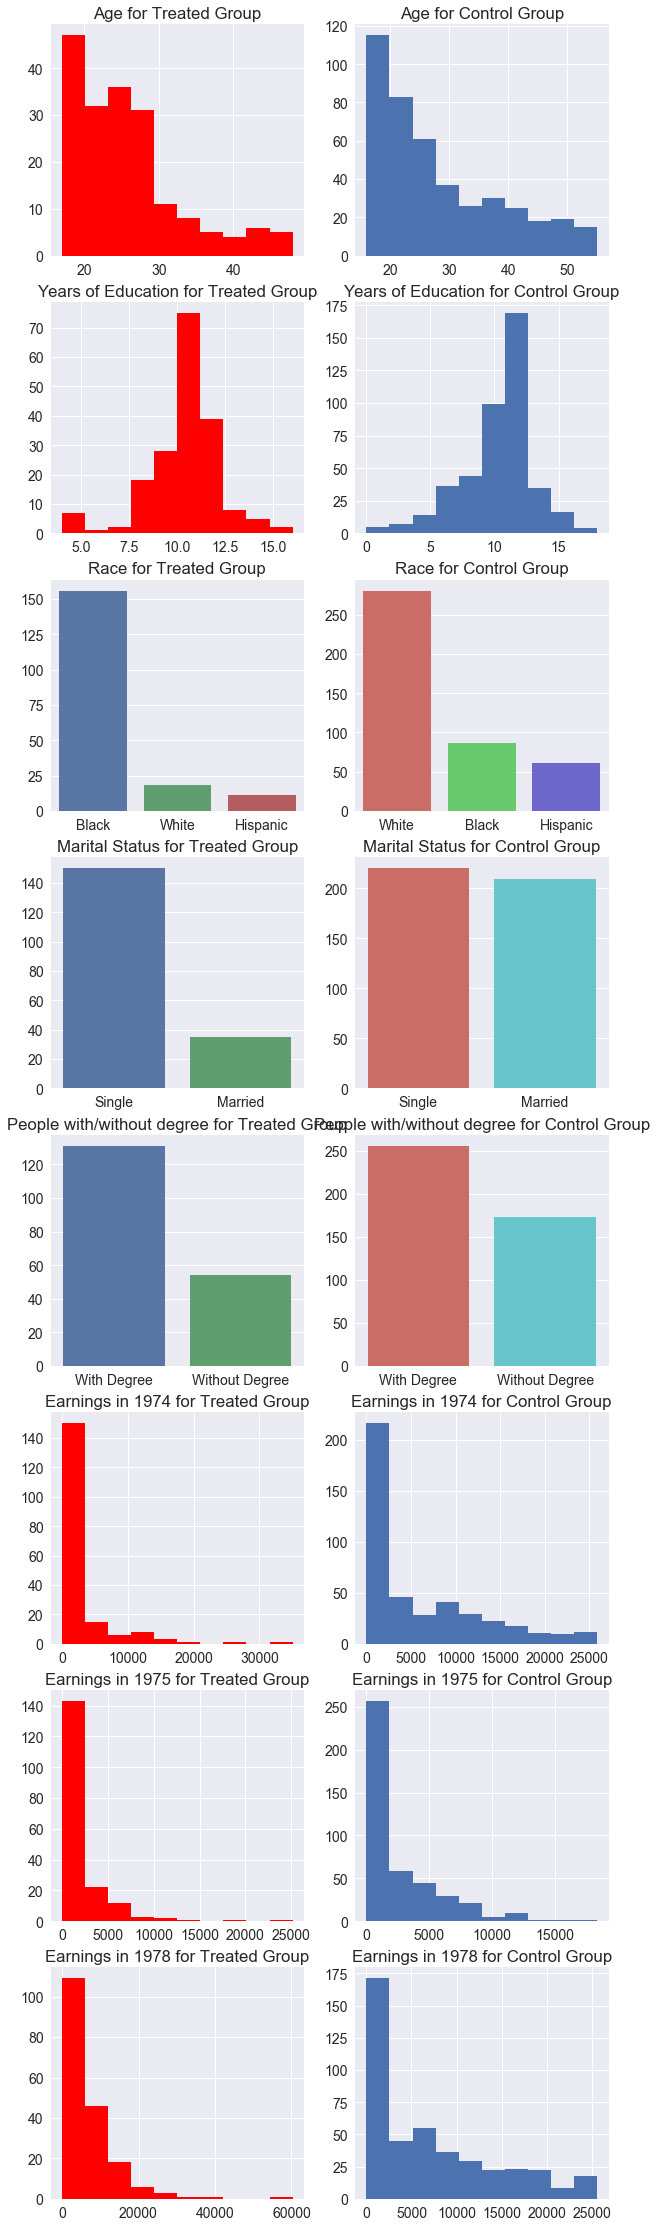

In [239]:
fig, axes = plt.subplots(8, 2, figsize=(10,40))

x  = np.array(la[la['treat']==1]['age'])
y = np.array(la[la['treat']==0]['age'])

ay = plt.subplot(8, 2, 1)
ay.set_title('Age for Treated Group')
plt.hist(x, color = 'red')

ay = plt.subplot(8, 2, 2)
ay.set_title('Age for Control Group')
plt.hist(y)



x  = np.array(la[la['treat']==1]['educ'])
y = np.array(la[la['treat']==0]['educ'])

ay = plt.subplot(8, 2, 3)
ay.set_title('Years of Education for Treated Group')
plt.hist(x, color = 'red')

ay = plt.subplot(8, 2, 4)
ay.set_title('Years of Education for Control Group')
plt.hist(y)


ay = plt.subplot(8,2,5)
ay.set_title('Race for Treated Group')
x=la[la['treat']==1]['Race'].value_counts().keys().values
y=la[la['treat']==1]['Race'].value_counts().values
sns.barplot(x,y)


ay = plt.subplot(8,2,6)
ay.set_title('Race for Control Group')
x=la[la['treat']==0]['Race'].value_counts().keys().values
y=la[la['treat']==0]['Race'].value_counts().values
sns.barplot(x,y,palette = 'hls')


ay = plt.subplot(8,2,7)
ay.set_title('Marital Status for Treated Group')
x=['Single','Married']
y=la[la['treat']==1]['married'].value_counts().values
sns.barplot(x,y)


ay = plt.subplot(8,2,8)
ay.set_title('Marital Status for Control Group')
x=['Single', 'Married']
y=la[la['treat']==0]['married'].value_counts().values
sns.barplot(x,y, palette = 'hls')



ay = plt.subplot(8,2,9)
ay.set_title('People with/without degree for Treated Group')
x=['With Degree', 'Without Degree']
y=la[la['treat']==1]['nodegree'].value_counts().values
sns.barplot(x,y)


ay = plt.subplot(8,2,10)
ay.set_title('People with/without degree for Control Group')
x=['With Degree', 'Without Degree']
y=la[la['treat']==0]['nodegree'].value_counts().values
sns.barplot(x,y, palette = 'hls')


x  = np.array(la[la['treat']==1]['re74'])
y = np.array(la[la['treat']==0]['re74'])

ay = plt.subplot(8, 2, 11)
ay.set_title('Earnings in 1974 for Treated Group')
plt.hist(x, color = 'red')

ay = plt.subplot(8, 2, 12)
ay.set_title('Earnings in 1974 for Control Group')
plt.hist(y)



x  = np.array(la[la['treat']==1]['re75'])
y = np.array(la[la['treat']==0]['re75'])

ay = plt.subplot(8, 2, 13)
ay.set_title('Earnings in 1975 for Treated Group')
plt.hist(x, color = 'red')

ay = plt.subplot(8, 2, 14)
ay.set_title('Earnings in 1975 for Control Group')
plt.hist(y)

x  = np.array(la[la['treat']==1]['re78'])
y = np.array(la[la['treat']==0]['re78'])

ay = plt.subplot(8, 2, 15)
ay.set_title('Earnings in 1978 for Treated Group')
plt.hist(x, color = 'red')

ay = plt.subplot(8, 2, 16)
ay.set_title('Earnings in 1978 for Control Group')
plt.hist(y)

plt.show()


___

## Question 2: Applied ML

### Part 1

I. Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn ([link](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)).  
[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for term frequency–inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).

In [176]:
import scipy as sc
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix as cm
from itertools import product

#### Load the data

In [94]:
# Fetch the data and dispatch it in several variables
newsgroups_train = fetch_20newsgroups(subset='train')

cat_numbers = newsgroups_train.target
categories = newsgroups_train.target_names

#### Compute TFIDF features for every article

In [ ]:
# Instantiate the TFIDF vectorizer with stop_words removal and apply it on the data
vectorizer = TfidfVectorizer(stop_words='english')
vectors = vectorizer.fit_transform(newsgroups_train.data)

#### Split the dataset into a training, a testing and a validation

In [95]:
# Helper method that returns indices to split the original dataset
def get_train_validation_testing_rows(num_rows):
    permutations = np.random.permutation(num_rows)
    idx1 = int(num_rows * 0.8)
    idx2 = int(num_rows * 0.1)
    train_rows = permutations[:idx1]
    validation_rows = permutations[idx1: idx1 + idx2]
    testing_rows = permutations[idx1 + idx2:]
    return train_rows, validation_rows, testing_rows

# Actual indices for the three categories
train_rows, validation_rows, testing_rows = get_train_validation_testing_rows(cat_numbers.size)

# Split the original matrix into the three categories
train_matrix = vectors[train_rows]
validation_matrix = vectors[validation_rows]
testing_matrix = vectors[testing_rows]

# Split the original labels into the three categories
train_labels = cat_numbers[train_rows]
validation_labels = cat_numbers[validation_rows]
test_labels = cat_numbers[testing_rows]

### Part 2

Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the `feature_importances_` attribute of your random forest and discuss the obtained results.

#### Grid search

In [ ]:
# /!\ This cell takes a few hours to run /!\

# Grid search happens on another process so that the computation is non-blocking
from multiprocessing import Process, Manager

# Special dictionnary initialization that make it compatible with parallel reads
manager = Manager()
scores = manager.dict()

# Perform grid search. The range was chosen after performing some initial gird searches that suggested to aim for high\
# parameters
def grid_search():
    for n_estimators, max_depth in product(range(30, 80), range(50, 80)):
        classifier = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
        classifier.fit(train_matrix, train_labels)
        accuracy = classifier.score(validation_matrix, validation_labels)
        scores[(n_estimators, max_depth)] = accuracy
        print('Progression:', (n_estimators - 30) / 50)
        print(accuracy)
        
p = Process(target=grid_search)
p.start()

In [231]:
scores_d = dict(scores)
best_tuple = max(scores_d, key=scores_d.get)

print('Best tuple:', best_tuple, ' with score:', scores_d[best_tuple])

Best tuple: (70, 79)  with score: 0.863837312113


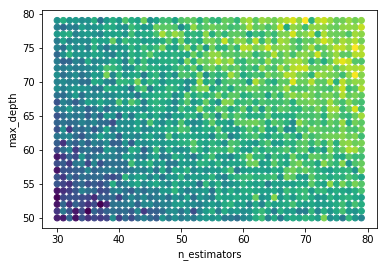

In [232]:
# Plot the grid search results

scores_l = list(scores_d.items())
x = np.array(list(map(lambda t: t[0][0], scores_l)))
y = np.array(list(map(lambda t: t[0][1], scores_l)))
c = np.array(list(map(lambda t: t[1], scores_l)))

plt.scatter(x,y,c=c)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.show()

The plot above represents the accuracy (encoded in a color w/ blue for low, green for medium and yellow for high) of the model as a function of its parameters.

With no big surprise, the score improves as we increase the value for both parameters. The trend emphasize that we could get a better score by trying higher parameters. However, performing this grid search is already very long and the improvement we get in the end is not really significant.  

#### Train a random forest on the training set (with best parameters)

In [215]:
classifier = RandomForestClassifier(n_estimators=best_tuple[0], max_depth=best_tuple[1])
classifier.fit(train_matrix, train_labels)
predicted_labels = classifier.predict(testing_matrix)

#### Display a confusion matrix of the classification pipeline

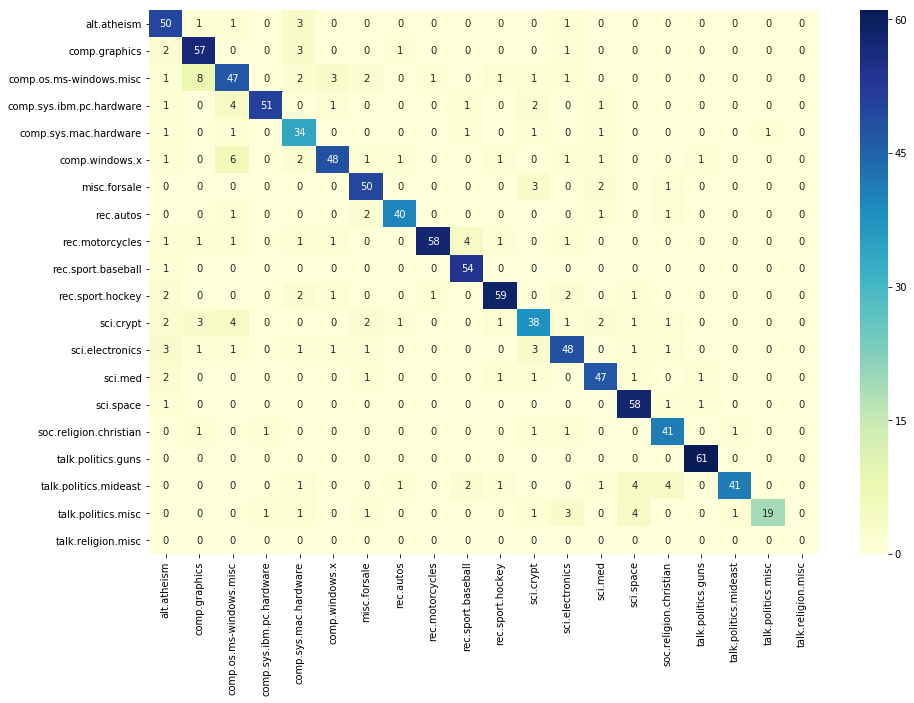

In [216]:
confusion_matrix = cm(test_labels, predicted_labels, labels=range(1, len(categories)+1))

df_cm = pd.DataFrame(confusion_matrix, categories,
                  categories)
plt.figure(figsize = (15,10))

sns.heatmap(df_cm,
            cmap="YlGnBu",
            annot=True,
            annot_kws={"size": 10}
            )
plt.show()

The confusion matrix confirms that our model is performing well. However, we can notice comp.os.ms-windows.misc is misqualified ofthen compared to other subject. It is nethertheless not that penalizing as the misqualifiaction concern topics that are really close (e.g. comp.windows.x).  

#### Inspect the features importance

In [217]:
# Get the word list sorted by index
vocabulary = {v: k for k, v in vectorizer.vocabulary_.items()}
words_indexed = np.array(list(map(lambda i: vocabulary[i], sorted(vocabulary))))

In [234]:
# Get the best features indices
feature_importances = classifier.feature_importances_
best_features_indices = np.argsort(feature_importances)

# Map best features indices to their corresponding words and output the top 30
words_indexed[best_features_indices[-30:]]

array(['writes', 'chip', 'christians', 'bible', 'orbit', 'nhl',
       'christian', 'key', 'moon', 'atheists', 'baseball', 'season',
       'government', 'graphics', 'athos', 'rutgers', 'mac', 'team', 'gun',
       'jesus', 'car', 'encryption', 'space', 'bike', 'god', 'clipper',
       'dod', 'windows', 'hockey', 'sale'],
      dtype='<U180')

The previous print shows the words have the strongest weights in our model. After inspecting this list, we get an intuition on how our model works. Indeed, we can see that it gives more weight to word that are directly linked to some of the categories. 